# CLASSIFICATION

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
import pydotplus 
from IPython.display import Image 
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

***

In [2]:
# UTILITY FUNCTIONS

#function to discretize the variables, categorical, to numerical
#input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

#metrics computed on the test set
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=classes))

***

In [3]:
# Starting dataset
df = pd.read_csv('clustered_dataframe.csv', sep='\t', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4333 entries, 17850 to 12713
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TProd           4333 non-null   int64  
 1   DProd           4333 non-null   int64  
 2   MeanProdOrder   4333 non-null   float64
 3   TSale           4333 non-null   float64
 4   MinPSale        4333 non-null   float64
 5   MaxPSale        4333 non-null   float64
 6   MeanSaleOrder   4333 non-null   float64
 7   TRProd          4333 non-null   int64  
 8   MeanPSale       4333 non-null   float64
 9   TOrder          4333 non-null   int64  
 10  SETSaleQta      4333 non-null   float64
 11  SESaleQtaOrder  4333 non-null   float64
 12  MaxOrderMonth   4333 non-null   object 
 13  Label           4333 non-null   object 
dtypes: float64(8), int64(4), object(2)
memory usage: 507.8+ KB


In [4]:
# we only have 2 categorical attributes, discretize them and get rid of them
df = discretize_data(df,['MaxOrderMonth','Label'])
df.drop(columns=['MaxOrderMonth','Label'], inplace=True, errors='ignore')
df_class = df.copy()
df_class.tail()

,TProd,DProd,MeanProdOrder,TSale,MinPSale,MaxPSale,MeanSaleOrder,TRProd,MeanPSale,TOrder,SETSaleQta,SESaleQtaOrder,MaxOrderMonth_num,Label_num
CustomerID,,,,,,,,,,,,,,
13436,76,12,76.0,196.89,10.20,25.50,196.89,0,5.830,1,3.418,0.0,1,1
15520,314,18,314.0,343.50,9.48,34.68,343.50,0,1.724,1,2.997,0.0,1,1
13298,96,2,96.0,360.00,90.00,270.00,360.00,0,3.750,1,1.000,0.0,1,1
14569,79,10,79.0,227.39,1.65,122.40,227.39,0,3.920,1,3.418,0.0,1,1
12713,505,37,505.0,794.55,5.04,71.70,794.55,0,2.085,1,4.101,0.0,11,2


In [5]:
#to classify, we first need to split the dataset into train and test dataset.
#we can do so using train_test_split, in this case we select a stratified split
label = df_class.pop('Label_num')
train_set, test_set, train_label, test_label = train_test_split(df_class, label, test_size=0.30)

In [6]:
# before starting classification we apply stratification to test set to have more data in less populated class
# we do this because otherwise our test set would be populated of < 10 elements for High_Spend class, giving a susceptible evaluation  
strat = {1: Counter(test_label)[1], 2: Counter(test_label)[2], 0: Counter(test_label)[2] }
smote = SMOTE(
    sampling_strategy=strat,    # resample all classes but the majority one
    k_neighbors=5
)
test_set, test_label = smote.fit_resample(test_set, test_label)
Counter(test_label)

Counter({1: 1148, 2: 142, 0: 142})

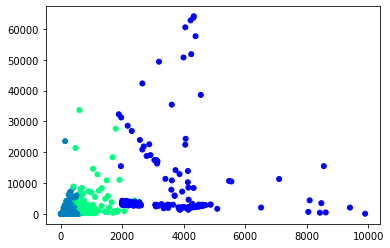

In [7]:
from sklearn.datasets import make_blobs
plt.scatter(test_set.iloc[:, 6].values, test_set.iloc[:, 0].values, c=test_label.values, s=25, cmap='winter');

***

### CLASSIFICATION PLAN:
* Apply classification on original train set i.e. high imbalance in data
* Apply classification on oversampled train set (toy oversampling method -> create new data by copying old over and over)
* Apply classification on oversampled train set (robust oversampling method -> SMOTE)

## CLASSIFICATION on ORIGINAL TRAIN SET

### Decision Tree (applied only in this part, only to illustrate the possible method results)

In [8]:
#define a decision tree and fit it
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best', 
                                  max_depth=10, 
                                  min_samples_split=3, min_samples_leaf=8)
dt = dt.fit(train_set, train_label)

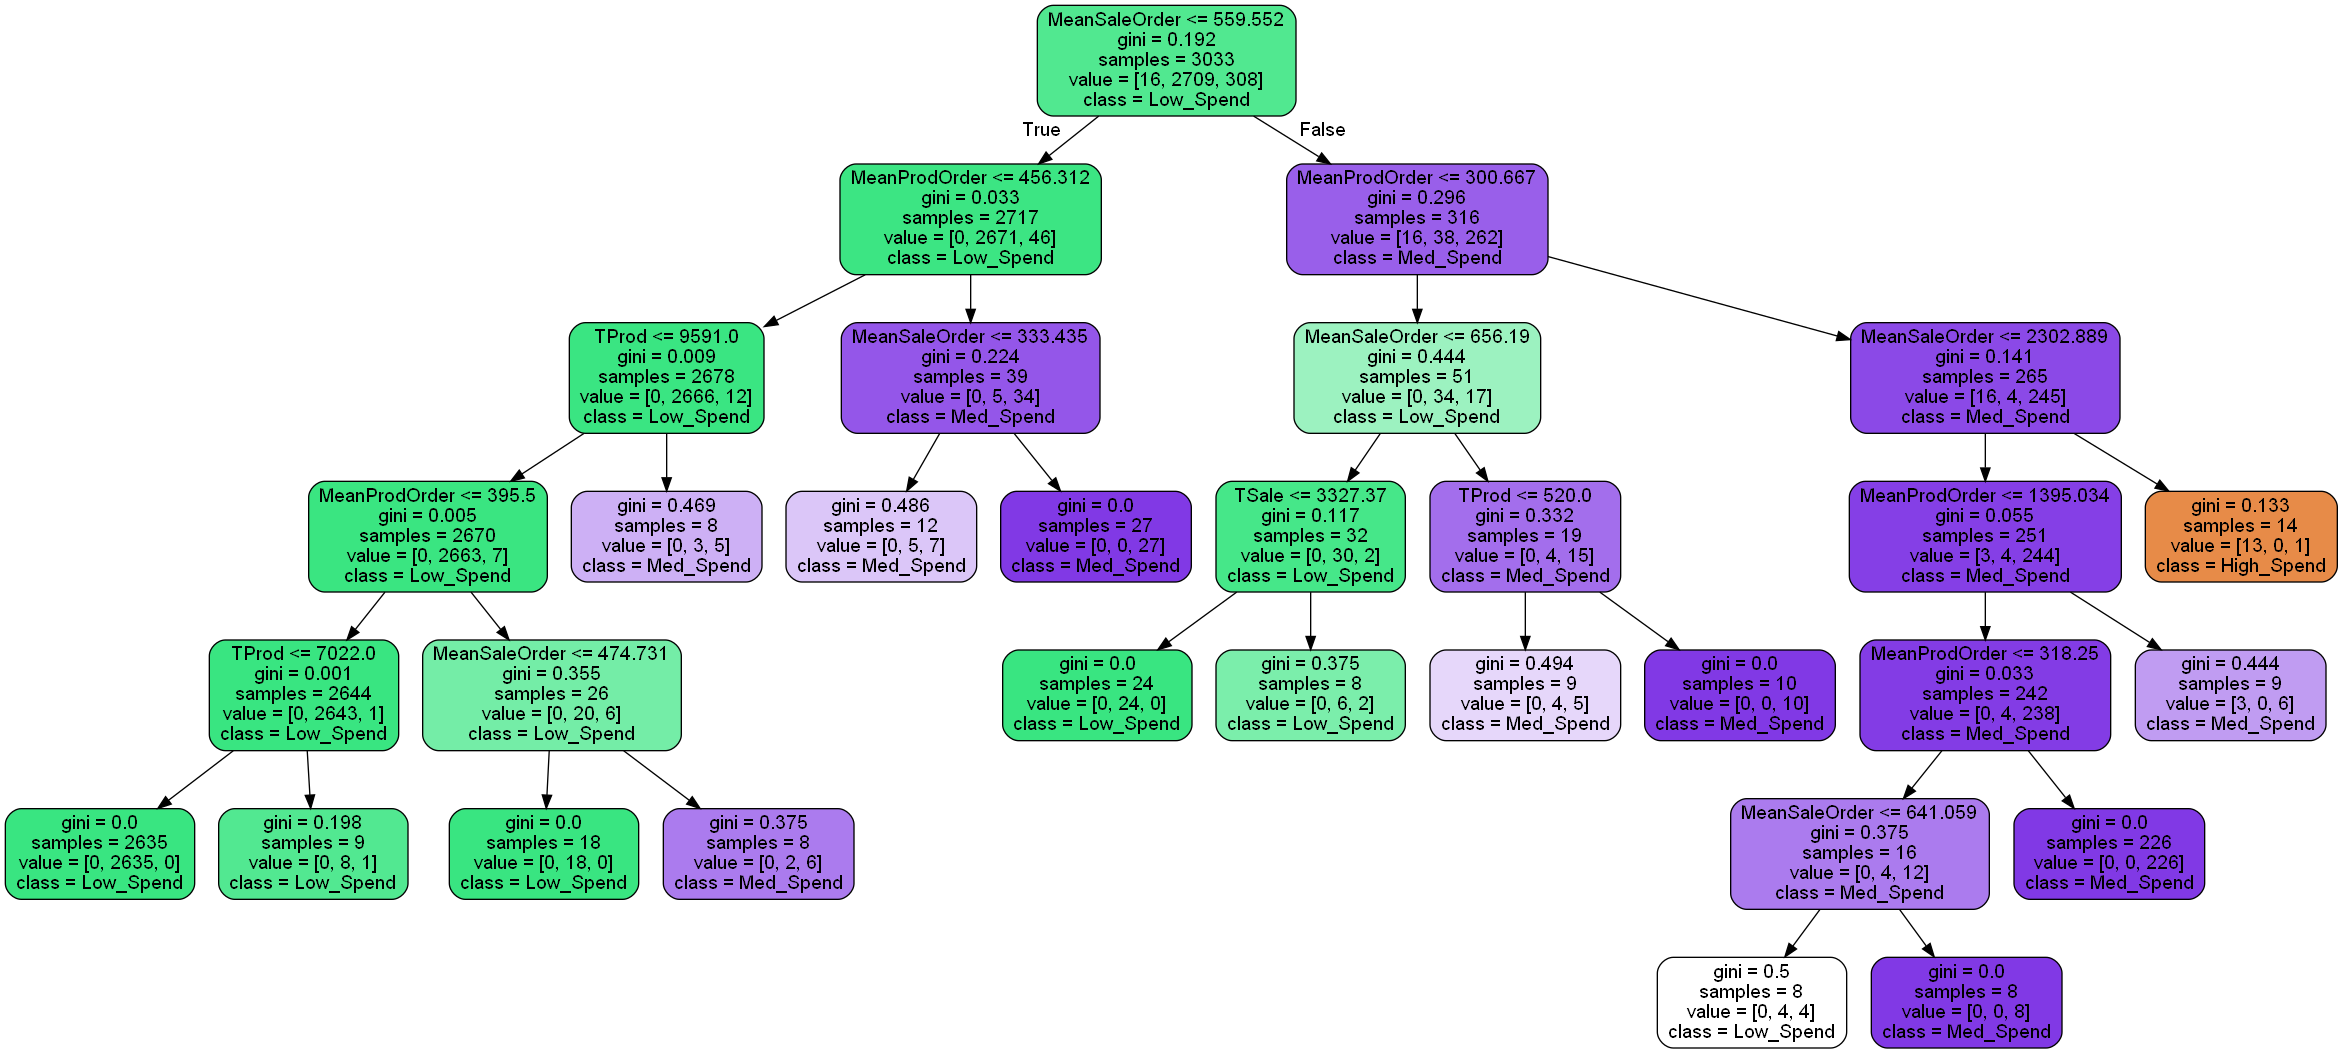

In [9]:
#visualize the actual decision tree obtained  
classes = ['High_Spend','Low_Spend','Med_Spend']
dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=classes,  #in transforming to numerical this order is mapped to 0,1,2 because of lexicographical
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [10]:
#predict using the decision tree
#the predict function returns the actual predicted labels: we need them for the evaluation phase
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

In [11]:
#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision train set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy train set  0.9917573359709858
Accuracy test set  0.9664804469273743
Precision train set  0.9918633887188882
Recall train set  0.9917573359709858
F1 score train set  0.9917682437275068
Support train set  (array([0.92857143, 0.99740933, 0.94637224]), array([0.8125    , 0.99483204, 0.97402597]), array([0.86666667, 0.99611902, 0.96      ]), array([  16, 2709,  308], dtype=int64))


In [12]:
report_scores(test_label, test_pred_dt)

              precision    recall  f1-score   support

  High_Spend       0.99      0.77      0.87       142
   Low_Spend       0.99      0.99      0.99      1148
   Med_Spend       0.77      0.95      0.85       142

    accuracy                           0.97      1432
   macro avg       0.92      0.91      0.90      1432
weighted avg       0.97      0.97      0.97      1432



In [13]:
#compute confusion matrix
cm = confusion_matrix(test_label, test_pred_dt)
cm

array([[ 110,    0,   32],
       [   0, 1139,    9],
       [   1,    6,  135]], dtype=int64)

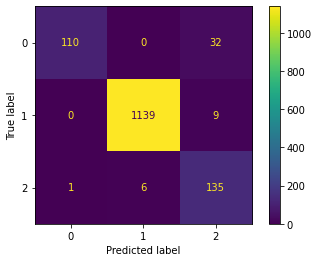

In [14]:
#it is possible to plot the confusion matrix 
plot_confusion_matrix(dt, test_set, test_label)
plt.show() 

### Random Forest

**Grid search for parameter setting**

In [15]:
#define the parameters' values you want to try
param_dist = {"max_depth": [2,3,5,6,7,10,12,None],
              "max_features": sp_randint(1, len(train_set.iloc[0]) + 1),
              "min_samples_split": sp_randint(3, 51),
              "min_samples_leaf": sp_randint(5, 51),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"]}
#define the number of iters
n_iter_search = 50
#define the model
clf = RandomForestClassifier(n_estimators=30)
#define the grid search
grid_search = RandomizedSearchCV(clf, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=1, 
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search.fit(train_set, train_label)

RandomizedSearchCV(estimator=RandomForestClassifier(n_estimators=30), n_iter=50,
                   n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [2, 3, 5, 6, 7, 10, 12,
                                                      None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FD28B01280>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FD28B297F0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FD28A63CA0>},
                   scoring=make_scorer(accuracy_score))

In [16]:
print('Best setting parameters ', grid_search.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0], 
      grid_search.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 7, 'max_features': 7, 'min_samples_leaf': 45, 'min_samples_split': 11}
Mean and std of this setting  0.972963935602786 0.0026781452513972596


In [17]:
grid_search.cv_results_['params'][0]

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 7,
 'max_features': 7,
 'min_samples_leaf': 45,
 'min_samples_split': 11}

In [18]:
rf = RandomForestClassifier(n_estimators=30, 
                             criterion=grid_search.cv_results_['params'][0]['criterion'],
                             max_features=grid_search.cv_results_['params'][0]['max_features'],
                             max_depth=grid_search.cv_results_['params'][0]['max_depth'], 
                             min_samples_split=grid_search.cv_results_['params'][0]['min_samples_split'],
                             min_samples_leaf=grid_search.cv_results_['params'][0]['min_samples_leaf'],
                             bootstrap=grid_search.cv_results_['params'][0]['bootstrap']) 
rf = rf.fit(train_set, train_label)

In [19]:
#prediction on the test test
test_pred_rf = rf.predict(test_set)

In [20]:
#compute the performance of the model
report_scores(test_label, test_pred_rf)

              precision    recall  f1-score   support

  High_Spend       0.00      0.00      0.00       142
   Low_Spend       0.98      1.00      0.99      1148
   Med_Spend       0.46      0.86      0.60       142

    accuracy                           0.88      1432
   macro avg       0.48      0.62      0.53      1432
weighted avg       0.83      0.88      0.85      1432



C:\Users\beppe\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


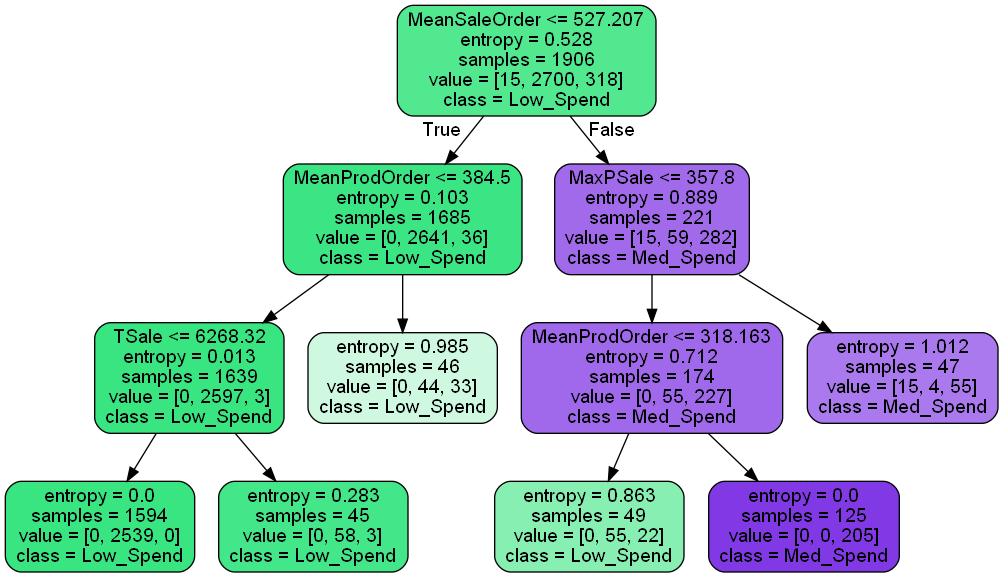

In [21]:
# forest is composed of lots of dt, visualize one just for fun
dot_data = tree.export_graphviz(rf[0], out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=classes,
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

### Naive Bayes

In [22]:
#define and fit the model
gnb = GaussianNB()
gnb.fit(train_set, train_label)

#predict on the test set
test_pred_gnb = gnb.predict(test_set)

In [23]:
#compute the performance of the model
report_scores(test_label,test_pred_gnb)

              precision    recall  f1-score   support

  High_Spend       0.96      0.90      0.93       142
   Low_Spend       0.97      0.97      0.97      1148
   Med_Spend       0.66      0.73      0.69       142

    accuracy                           0.94      1432
   macro avg       0.87      0.86      0.86      1432
weighted avg       0.94      0.94      0.94      1432



### KNN

In [24]:
knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree', metric='minkowski').fit(train_set, train_label)

#prediction on the test test
test_pred_knn = knn.predict(test_set)

In [25]:
#compute the performance of the model
report_scores(test_label,test_pred_knn)

              precision    recall  f1-score   support

  High_Spend       1.00      0.16      0.28       142
   Low_Spend       0.97      1.00      0.98      1148
   Med_Spend       0.46      0.73      0.57       142

    accuracy                           0.89      1432
   macro avg       0.81      0.63      0.61      1432
weighted avg       0.92      0.89      0.87      1432



### SVM

In [26]:
svm = SVC(kernel='sigmoid', C=0.6, gamma='scale', probability=True)
svm.fit(train_set, train_label)

SVC(C=0.6, kernel='sigmoid', probability=True)

In [27]:
#prediction on the test test
test_pred_proba_svm = svm.predict_proba(test_set)

In [28]:
test_pred_svm = svm.predict(test_set)

In [29]:
#compute the performance of the model (only oversample because without it no element is classified as High_Spend)
print(classification_report(test_label, 
                            test_pred_svm, 
                            target_names=classes))

              precision    recall  f1-score   support

  High_Spend       0.00      0.00      0.00       142
   Low_Spend       0.91      0.99      0.95      1148
   Med_Spend       0.14      0.18      0.16       142

    accuracy                           0.81      1432
   macro avg       0.35      0.39      0.37      1432
weighted avg       0.74      0.81      0.77      1432



C:\Users\beppe\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***

## CLASSIFICATION on OVERSAMPLED TRAIN SET (BASIC OVERSAMPLING)

Just to reiterate the concept, taking a look at our data distribution between our 3 classes 
we can see how it is very unbalanced! This can be fixed by stratification, which can be done in many ways..

In [30]:
Counter(train_label)

Counter({1: 2709, 2: 308, 0: 16})

In [31]:
# define oversampling strategy
from imblearn.over_sampling import RandomOverSampler
highest = Counter(train_label)[1]
fraction = 4
strat = {1: highest, 2: math.ceil(highest / fraction), 0: math.ceil(highest / fraction) }
oversample = RandomOverSampler(sampling_strategy=strat)
train_set_over, train_label_over = oversample.fit_resample(train_set,train_label)

In [32]:
Counter(train_label_over)

Counter({1: 2709, 2: 678, 0: 678})

### Random Forest

Try grid search again, on this more balanced dataset

In [33]:
#define the parameters' values you want to try
num_estimators = 30
param_dist = {"max_depth": [3,5,6,7,10,12,None],
              "max_features": sp_randint(1, 10),
              "min_samples_split": sp_randint(3, 20),
              "min_samples_leaf": sp_randint(5, 20),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"]}
clf_over = RandomForestClassifier(n_estimators=num_estimators)
#define the grid search
grid_search_over = RandomizedSearchCV(clf_over, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=1, 
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_over.fit(train_set_over, train_label_over)

RandomizedSearchCV(estimator=RandomForestClassifier(n_estimators=30), n_iter=50,
                   n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [3, 5, 6, 7, 10, 12, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FD28705310>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FD205242E0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FD28705EE0>},
                   scoring=make_scorer(accuracy_score))

In [34]:
print('Best setting parameters ', grid_search_over.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search_over.cv_results_['mean_test_score'][0], 
      grid_search_over.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': False, 'criterion': 'gini', 'max_depth': 6, 'max_features': 5, 'min_samples_leaf': 15, 'min_samples_split': 10}
Mean and std of this setting  0.9931119311193111 0.0028688570208340917


In [35]:
rf_over = RandomForestClassifier(n_estimators=num_estimators, 
                             criterion=grid_search_over.cv_results_['params'][0]['criterion'],
                             max_features=grid_search_over.cv_results_['params'][0]['max_features'],
                             max_depth=grid_search_over.cv_results_['params'][0]['max_depth'], 
                             min_samples_split=grid_search_over.cv_results_['params'][0]['min_samples_split'],
                             min_samples_leaf=grid_search_over.cv_results_['params'][0]['min_samples_leaf'],
                             bootstrap=grid_search_over.cv_results_['params'][0]['bootstrap'])
rf_over = rf_over.fit(train_set_over, train_label_over)

In [36]:
#prediction on the test test
test_pred_rf = rf_over.predict(test_set)

In [37]:
#compute the performance of the model
report_scores(test_label, test_pred_rf)

              precision    recall  f1-score   support

  High_Spend       1.00      0.80      0.89       142
   Low_Spend       1.00      0.99      1.00      1148
   Med_Spend       0.80      0.97      0.88       142

    accuracy                           0.97      1432
   macro avg       0.93      0.92      0.92      1432
weighted avg       0.98      0.97      0.97      1432



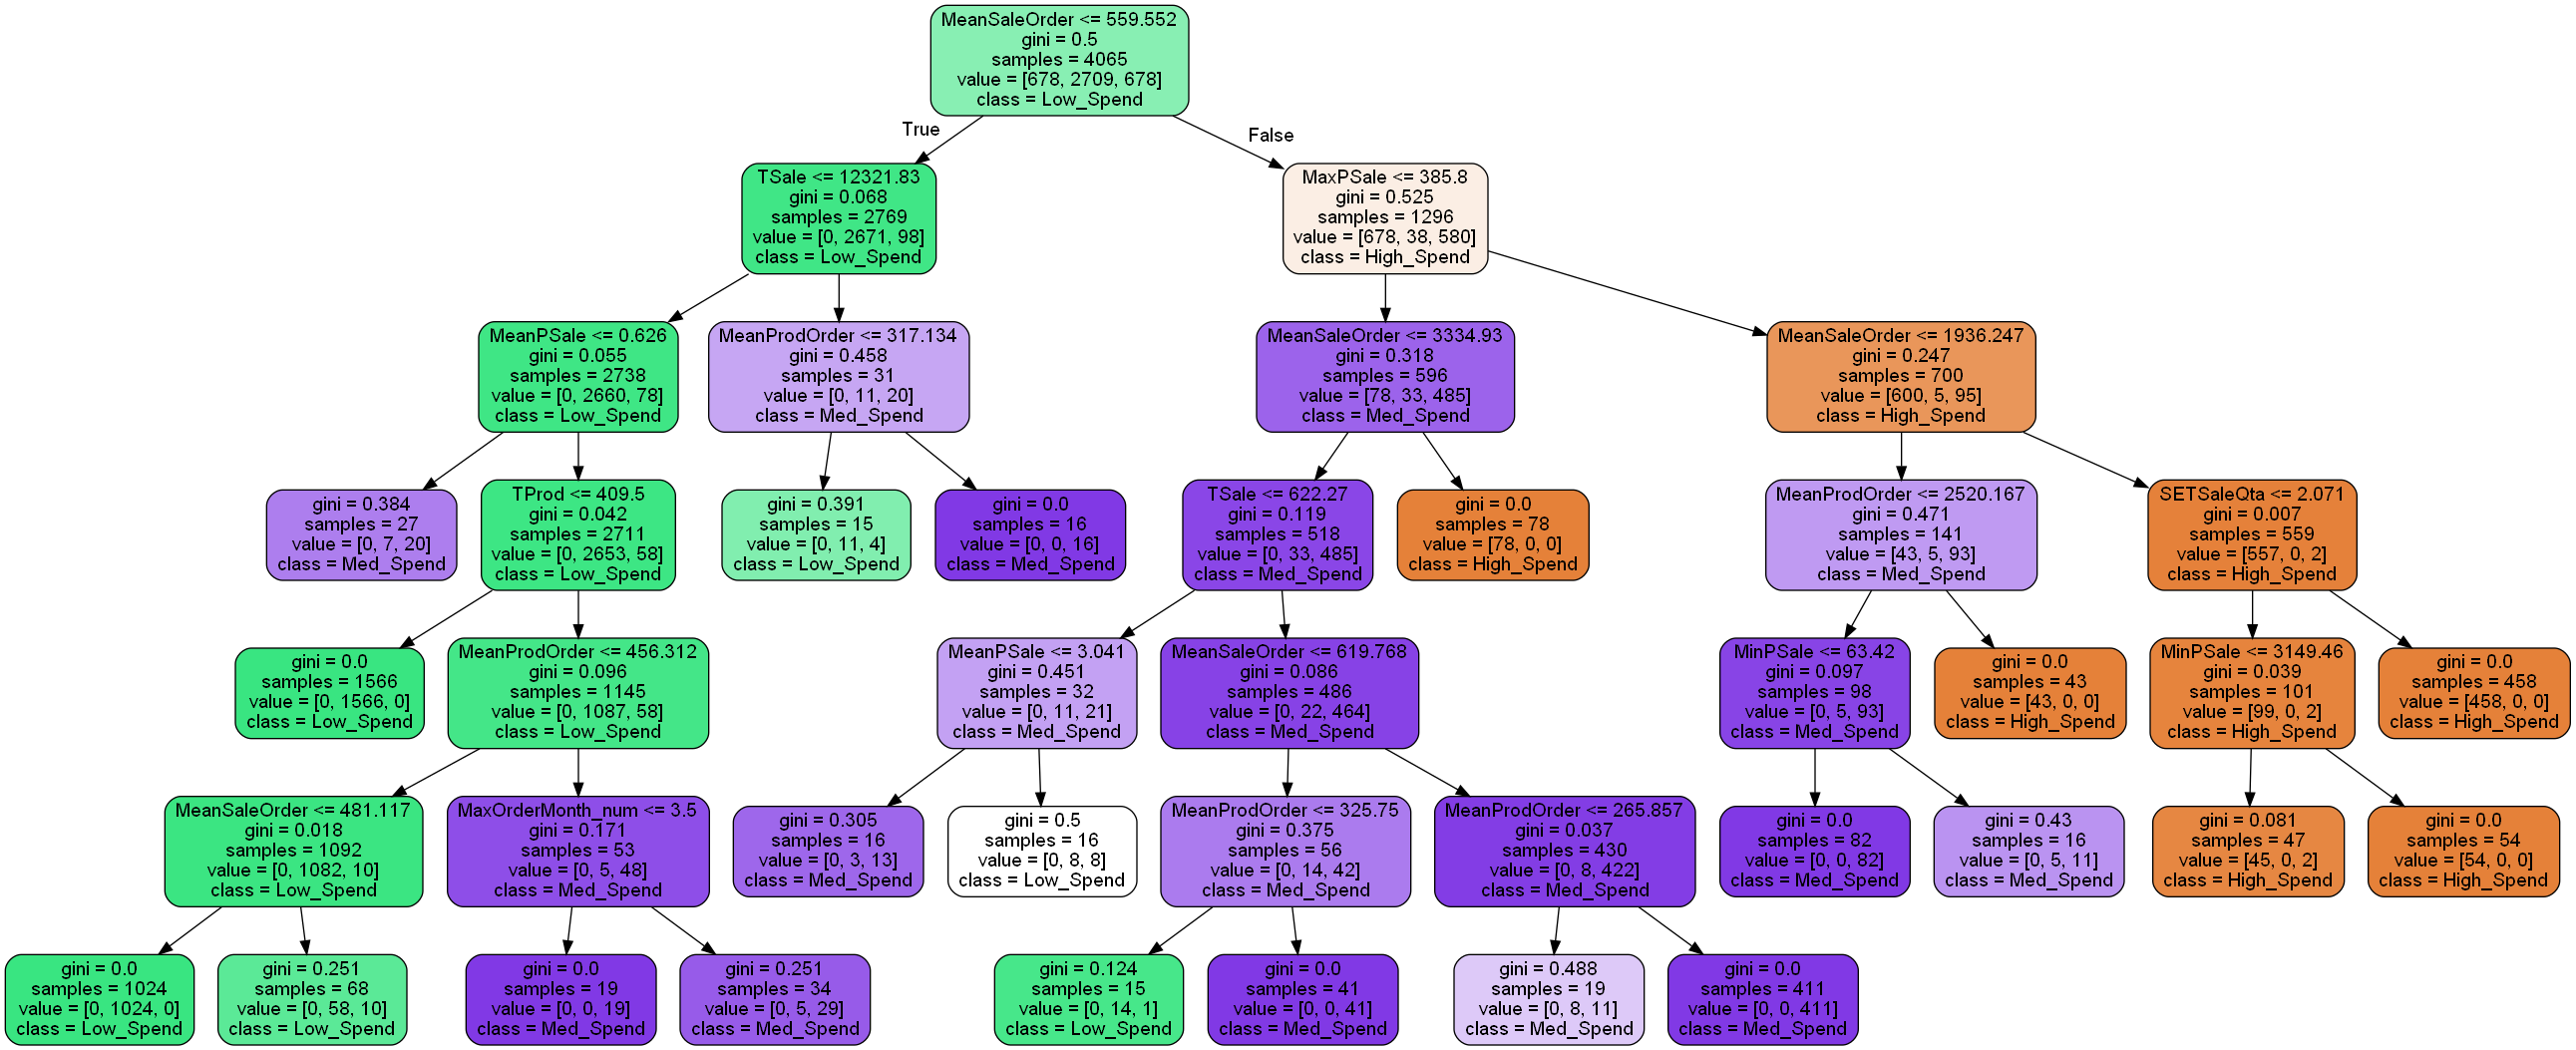

In [38]:
# forest is composed of lots of dt, visualize one just for fun
dot_data_over = tree.export_graphviz(rf_over[0], out_file=None, 
                         feature_names=list(train_set_over.columns),  
                         class_names=classes,
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data_over)  
Image(graph.create_png())

### Naive Bayes

In [39]:
gnb = GaussianNB()
gnb.fit(train_set_over, train_label_over)

#predict on the test set
test_pred_gnb = gnb.predict(test_set)

In [40]:
#compute the performance of the model
report_scores(test_label,test_pred_gnb)

              precision    recall  f1-score   support

  High_Spend       0.96      0.90      0.93       142
   Low_Spend       0.97      0.96      0.97      1148
   Med_Spend       0.66      0.75      0.71       142

    accuracy                           0.94      1432
   macro avg       0.87      0.87      0.87      1432
weighted avg       0.94      0.94      0.94      1432



# Classification with KNN

In [41]:
knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree', metric='minkowski').fit(train_set_over, train_label_over)

#prediction on the test test
test_pred_knn = knn.predict(test_set)

In [42]:
#compute the performance of the model
report_scores(test_label,test_pred_knn)

              precision    recall  f1-score   support

  High_Spend       1.00      0.64      0.78       142
   Low_Spend       0.98      0.99      0.98      1148
   Med_Spend       0.66      0.86      0.75       142

    accuracy                           0.94      1432
   macro avg       0.88      0.83      0.84      1432
weighted avg       0.95      0.94      0.94      1432



# Classification with SVM

In [43]:
svm = SVC(kernel='sigmoid', C=0.6, gamma='scale', probability=True)
svm.fit(train_set_over, train_label_over)

SVC(C=0.6, kernel='sigmoid', probability=True)

In [44]:
#prediction on the test test
test_pred_proba_svm = svm.predict_proba(test_set)

In [45]:
test_pred_svm = svm.predict(test_set)

In [46]:
#compute the performance of the model (only oversample because without it no element is classified as High_Spend)
print(classification_report(test_label, 
                            test_pred_svm, 
                            target_names=classes))

              precision    recall  f1-score   support

  High_Spend       0.56      0.42      0.48       142
   Low_Spend       0.89      0.95      0.92      1148
   Med_Spend       0.28      0.19      0.23       142

    accuracy                           0.82      1432
   macro avg       0.58      0.52      0.54      1432
weighted avg       0.79      0.82      0.80      1432



***

## CLASSIFICATION on OVERSAMPLED TRAIN SET (SMOTE)

SMOTE is a different stratification method which still applies oversampling to the classes. The difference between this method and the basic oversampling applied before stands in the generation of new data:
* in the basic oversampling, original data was simply copied to create exact (but additional) new data
* in SMOTE oversampling, original data is used to create new data which copy the old one adding a [0,1] perturbation, hence generating truly new data

In [47]:
smote = SMOTE(
    sampling_strategy=strat,    # resample all classes but the majority one
    k_neighbors=5
)

train_set_smote, train_label_smote = smote.fit_resample(train_set, train_label)

In [48]:
Counter(train_label_smote)

Counter({1: 2709, 2: 678, 0: 678})

### Random Forest

Try grid search again, on this even more balanced dataset

In [49]:
#define the parameters' values you want to try
num_estimators = 30
param_dist = {"max_depth": [3,5,6,7,10,12,None],
              "max_features": sp_randint(1, 10),
              "min_samples_split": sp_randint(3, 20),
              "min_samples_leaf": sp_randint(5, 20),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"]}
clf_smote = RandomForestClassifier(n_estimators=num_estimators)
#define the grid search
grid_search_smote = RandomizedSearchCV(clf_smote, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=1, 
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_smote.fit(train_set_smote, train_label_smote)

RandomizedSearchCV(estimator=RandomForestClassifier(n_estimators=30), n_iter=50,
                   n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [3, 5, 6, 7, 10, 12, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FD29DC2100>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FD29DC2520>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FD29DC22E0>},
                   scoring=make_scorer(accuracy_score))

In [50]:
print('Best setting parameters ', grid_search_smote.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search_smote.cv_results_['mean_test_score'][0], 
      grid_search_smote.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': False, 'criterion': 'gini', 'max_depth': 12, 'max_features': 9, 'min_samples_leaf': 16, 'min_samples_split': 11}
Mean and std of this setting  0.9889298892988929 0.0017395000767196976


In [51]:
rf_smote = RandomForestClassifier(n_estimators=num_estimators, 
                             criterion=grid_search_smote.cv_results_['params'][0]['criterion'],
                             max_features=grid_search_smote.cv_results_['params'][0]['max_features'],
                             max_depth=grid_search_smote.cv_results_['params'][0]['max_depth'], 
                             min_samples_split=grid_search_smote.cv_results_['params'][0]['min_samples_split'],
                             min_samples_leaf=grid_search_smote.cv_results_['params'][0]['min_samples_leaf'],
                             bootstrap=grid_search_smote.cv_results_['params'][0]['bootstrap'])
rf_smote = rf_smote.fit(train_set_smote, train_label_smote)

In [52]:
#prediction on the test test
test_pred_rf = rf_smote.predict(test_set)

In [53]:
#compute the performance of the model
report_scores(test_label, test_pred_rf)

              precision    recall  f1-score   support

  High_Spend       0.99      0.88      0.93       142
   Low_Spend       1.00      0.99      0.99      1148
   Med_Spend       0.81      0.96      0.88       142

    accuracy                           0.97      1432
   macro avg       0.93      0.94      0.94      1432
weighted avg       0.98      0.97      0.97      1432



### Naive Bayes

In [54]:
gnb = GaussianNB()
gnb.fit(train_set_smote, train_label_smote)

#predict on the test set
test_pred_gnb = gnb.predict(test_set)

In [55]:
#compute the performance of the model
report_scores(test_label,test_pred_gnb)

              precision    recall  f1-score   support

  High_Spend       0.93      0.90      0.92       142
   Low_Spend       0.98      0.96      0.97      1148
   Med_Spend       0.67      0.76      0.71       142

    accuracy                           0.94      1432
   macro avg       0.86      0.88      0.87      1432
weighted avg       0.94      0.94      0.94      1432



### KNN

In [56]:
knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree', metric='minkowski').fit(train_set_smote, train_label_smote)

#prediction on the test test
test_pred_knn = knn.predict(test_set)

In [57]:
#compute the performance of the model
report_scores(test_label,test_pred_knn)

              precision    recall  f1-score   support

  High_Spend       0.98      0.89      0.93       142
   Low_Spend       0.98      0.99      0.98      1148
   Med_Spend       0.79      0.81      0.80       142

    accuracy                           0.96      1432
   macro avg       0.92      0.89      0.91      1432
weighted avg       0.96      0.96      0.96      1432



### SVM

In [58]:
svm = SVC(kernel='sigmoid', C=0.6, gamma='scale', probability=True)
svm.fit(train_set_smote, train_label_smote)

SVC(C=0.6, kernel='sigmoid', probability=True)

In [59]:
#prediction on the test test
test_pred_proba_svm = svm.predict_proba(test_set)

In [60]:
test_pred_svm = svm.predict(test_set)

In [61]:
#compute the performance of the model (only oversample because without it no element is classified as High_Spend)
print(classification_report(test_label, 
                            test_pred_svm, 
                            target_names=classes))

              precision    recall  f1-score   support

  High_Spend       0.48      0.63      0.54       142
   Low_Spend       0.91      0.95      0.93      1148
   Med_Spend       0.02      0.01      0.01       142

    accuracy                           0.82      1432
   macro avg       0.47      0.53      0.49      1432
weighted avg       0.78      0.82      0.80      1432

